# 05 - Outlier Management (IQR + Isolation Forest)

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
pd.set_option('display.float_format', '{:.1f}'.format)
df = pd.read_csv("Numeric data (last year work).csv")

In [3]:
# define features and target
target_column = 'Rating'
X = df.drop(columns=[target_column])
y = df[target_column]

In [4]:
# Train Linear Regression on the Full Dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)
model_full = LinearRegression()
model_full.fit(X_train_full, y_train_full)
predictions_full = model_full.predict(X_test_full)

In [5]:
# Apply Outlier Management (IQR)
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect IQR-based outliers for all numeric columns
outliers_iqr = pd.DataFrame({col: detect_outliers_iqr(df[col]) for col in X.columns})

In [6]:
# Apply Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X)  # Fit on numeric columns
outliers_iso = iso_forest.predict(X)

# -1 indicates outliers, 1 indicates inliers
outliers_iso = (outliers_iso == -1)

In [7]:
# Combine IQR and Isolation Forest
combined_outliers = outliers_iqr.any(axis=1) | outliers_iso
print(f"Total combined outliers: {np.sum(combined_outliers)}")


Total combined outliers: 968


In [8]:
# Filter the dataset
X_cleaned = X[~combined_outliers]
y_cleaned = y[~combined_outliers]

# train Linear Regression on the Cleaned Dataset
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.3, random_state=42
)
model_cleaned = LinearRegression()
model_cleaned.fit(X_train_cleaned, y_train_cleaned)

LinearRegression()

In [ ]:
# Evaluate Linear Regression on the cleaned dataset
predictions_cleaned = model_cleaned.predict(X_test_cleaned)

print("\nMetrics After Outlier Management:")
print("MAE:", round(mean_absolute_error(y_test_cleaned, predictions_cleaned), 2))
print("MSE:", round(mean_squared_error(y_test_cleaned, predictions_cleaned), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_cleaned, predictions_cleaned)), 2))
print("R-squared:", round(r2_score(y_test_cleaned, predictions_cleaned), 2))

# insights:
# everything is improved except R-squared
# I think, the issues are the same as in the previous notebook


Metrics After Outlier Management:
MAE: 0.37
MSE: 0.23
RMSE: 0.48
R-squared: 0.22


C:\Users\e1003118\AppData\Local\Temp\ipykernel_20756\3260931098.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_full - predictions_full, kde=True, label='Before Outlier Management')
C:\Users\e1003118\AppData\Local\Temp\ipykernel_20756\3260931098.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

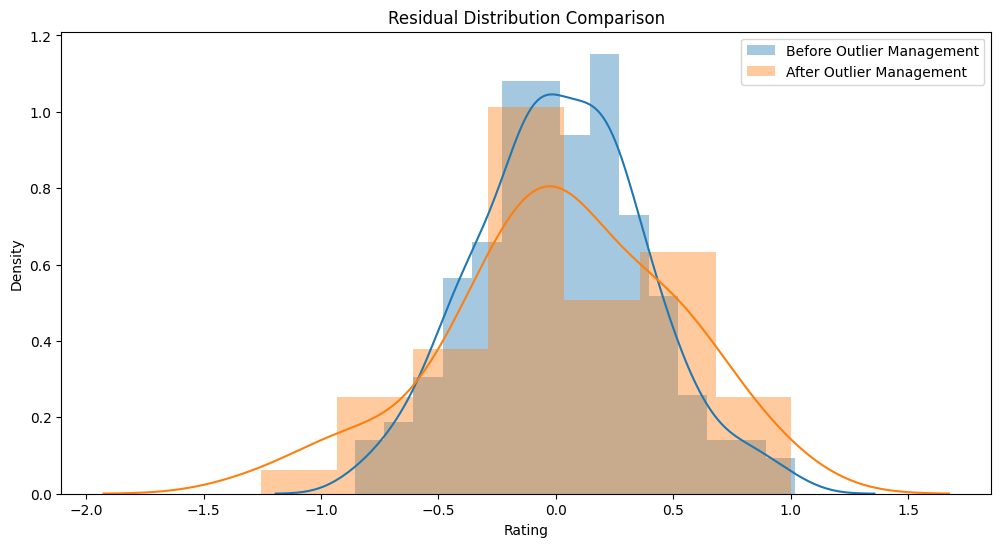

In [11]:
# Step 6: Visualize Residuals
plt.figure(figsize=(12, 6))
sns.distplot(y_test_full - predictions_full, kde=True, label='Before Outlier Management')
sns.distplot(y_test_cleaned - predictions_cleaned, kde=True, label='After Outlier Management')
plt.title('Residual Distribution Comparison')
plt.legend()
plt.show()

In [ ]:
# I like it more
# because it does not have 2 peaks

# but the orange curve largely overlaps 
# with the blue curve (before outlier management) 
# around 0, indicating that the model performs 
# similarly for most data points.

# however, the curve shows a sharper peak near 0, 
# suggesting that most predictions 
# are closer to their actual values
